In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds

# from IPython.core.interactiveshell import InteractiveShell


In [2]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [4]:
train_data.shape

(25000,)

In [5]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [6]:
# 由于神经网络要求输入必须一样 现在通过pad_sequences这个方法使每条评论长度为256 不够的话在后面填充<PAD>
train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                        value=word_index["<PAD>"], 
                                                        padding='post', 
                                                        maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data, 
                                                       value=word_index["<PAD>"], 
                                                       padding='post', 
                                                       maxlen=256)

In [7]:
# 构建模型
vocab_size = 10000

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 编译
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 取前10000个作为验证集
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

history = model.fit(partial_x_train, 
          partial_y_train, 
          validation_data=(x_val, y_val), 
          epochs=40, 
          batch_size=512, 
          verbose=1)

W0821 17:28:42.743319 4452369856 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 66us/sample - loss: 0.6919 - accuracy: 0.5491 - val_loss: 0.6901 - val_accuracy: 0.5719
Epoch 2/40
15000/15000 [==============================] - 1s 40us/sample - loss: 0.6866 - accuracy: 0.6506 - val_loss: 0.6827 - val_accuracy: 0.6928
Epoch 3/40
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6747 - accuracy: 0.7301 - val_loss: 0.6681 - val_accuracy: 0.7438
Epoch 4/40
15000/15000 [==============================] - 1s 36us/sample - loss: 0.6546 - accuracy: 0.7493 - val_loss: 0.6452 - val_accuracy: 0.7564
Epoch 5/40
15000/15000 [==============================] - 1s 37us/sample - loss: 0.6248 - accuracy: 0.7815 - val_loss: 0.6138 - val_accuracy: 0.7752
Epoch 6/40
15000/15000 [==============================] - 1s 38us/sample - loss: 0.5860 - accuracy: 0.8039 - val_loss: 0.5750 - val_accuracy: 0.7928
Epoch 7/40
15000/15000 [==============================] 

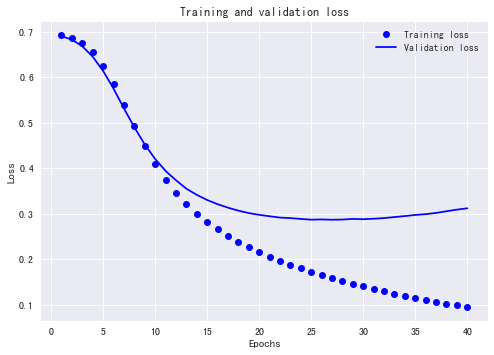

In [10]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

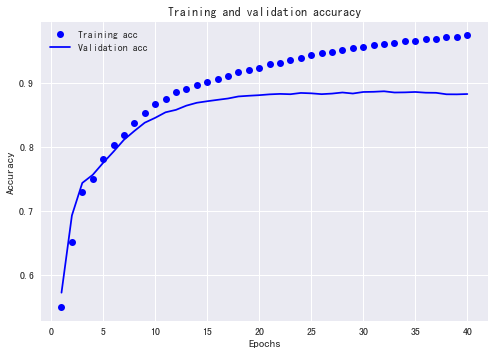

In [11]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()